<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


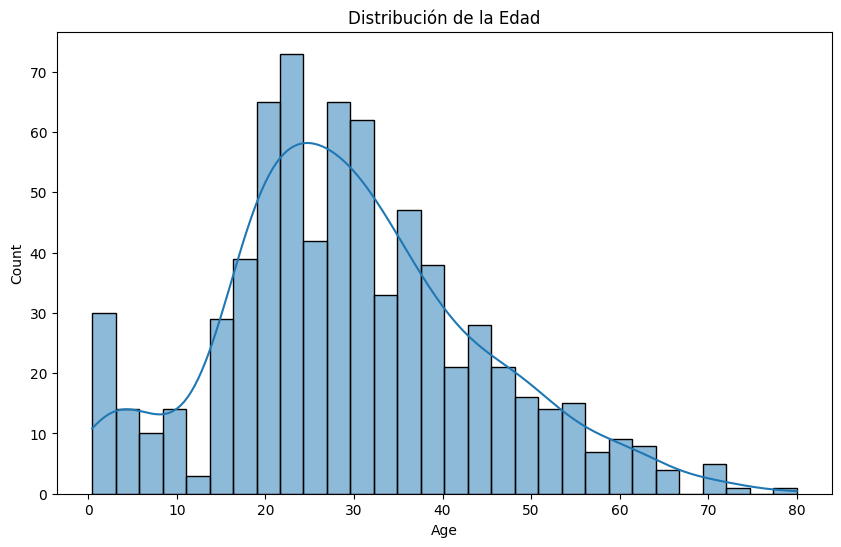

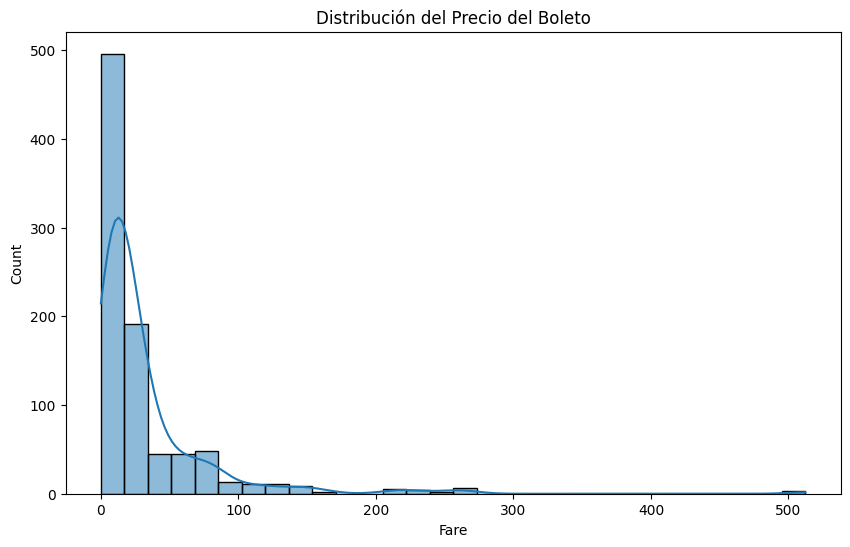

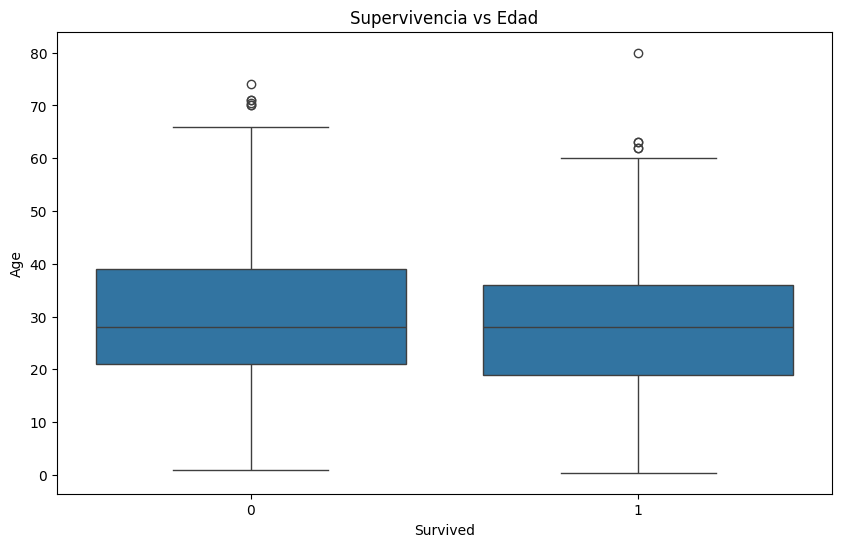

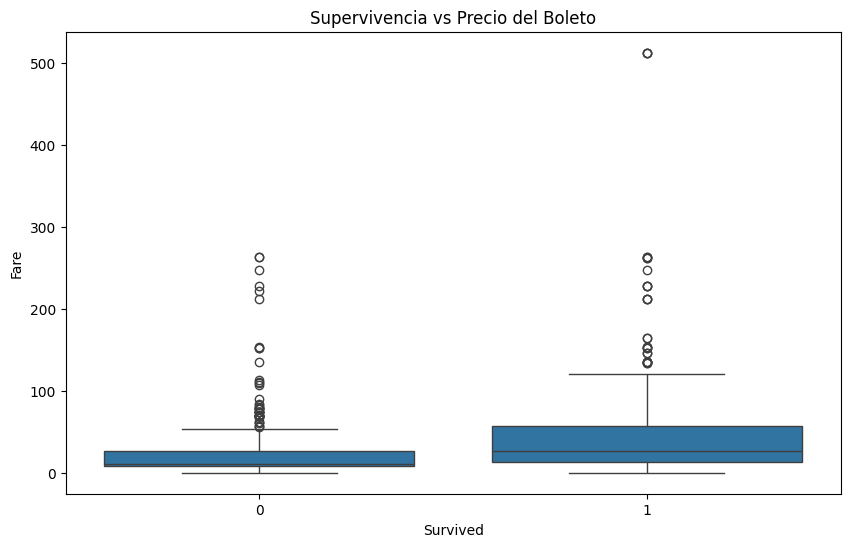

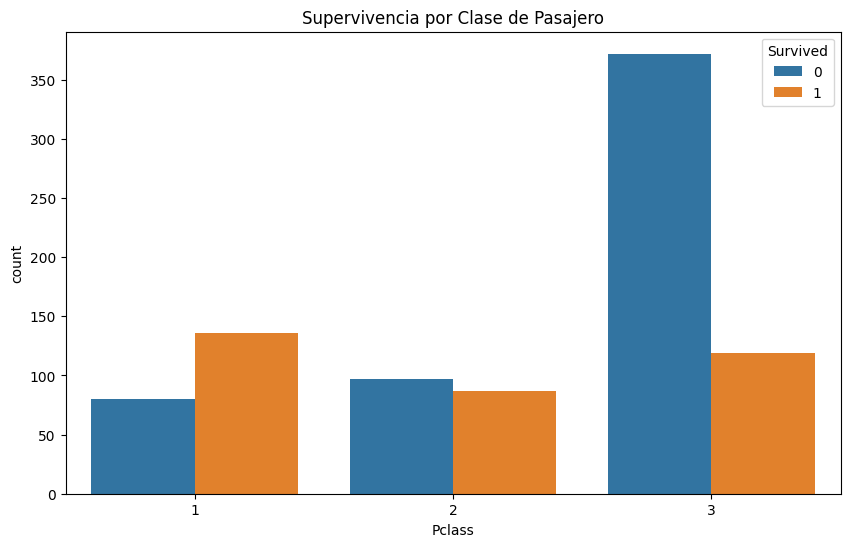

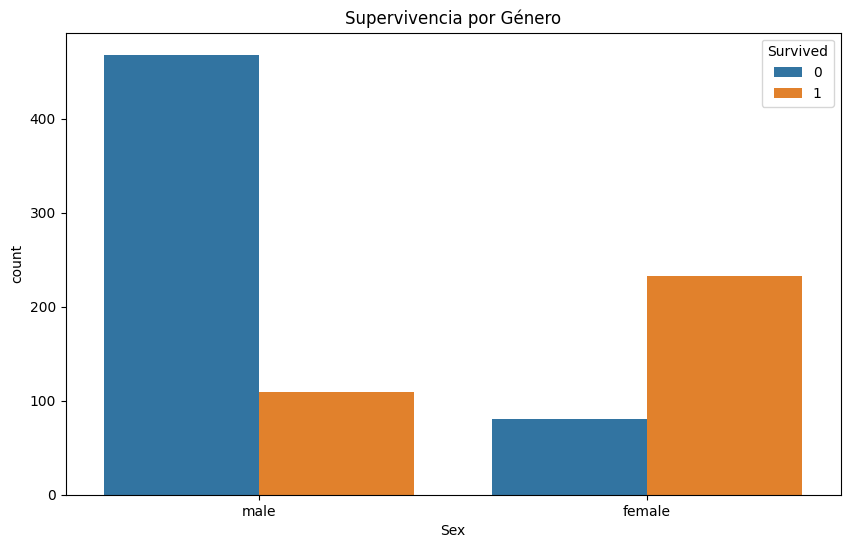

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar los datos
data_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(data_url)

# Visualización inicial
df.head()

# Descripción estadística
df.describe()

# Información sobre los datos
df.info()
df.isnull().sum()

# Análisis univariado
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Distribución de la Edad')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Fare'], kde=True, bins=30)
plt.title('Distribución del Precio del Boleto')
plt.show()

# Análisis bivariado
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Supervivencia vs Edad')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Supervivencia vs Precio del Boleto')
plt.show()

# Tratamiento de valores nulos
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

# Confirmación de que no hay valores nulos
df.isnull().sum()

# Visualización adicional
plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Supervivencia por Clase de Pasajero')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Supervivencia por Género')
plt.show()